# HSE 2021: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net). 

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$.

The optimization problem with respect to the $w_0, w$ is the following (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format) 

Градиент представляет собой частные производные по каждому из параметров $w_0$ и $w$, найдем их:   
$$\nabla_w L(w, w_0)=\frac{1}{N} \sum_{i=1}^N \ln'(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma (\|w\|_1)' + \beta (\|w\|_2^2)';$$
Примечание для производных норм разного порядка (по вектору $w$, по вектору $w_0$ они будут равны $0$):   
$$(\|w\|_1)'=\frac{\partial \|w\|_1}{\partial w}=\frac{\partial w ⋅sign(w)}{\partial w}=sign(w);$$   
$$\|w\|_2^2=\sum_{i=1} |w_i|^2=\sum_{i=1} w_i^2 ⇒(\|w\|_2^2)'=\frac{\partial \|w\|_2^2}{\partial w}=\frac{\partial w ⋅2w}{\partial w}=2w;$$  
Тогда получаем следующий результат:    
$$\nabla_w L(w, w_0)=\frac{1}{N} \sum_{i=1}^N \frac{(-y_i(w^\top x_i+w_0))' \cdot \exp(-y_i(w^\top x_i+w_0))}{1+\exp(-y_i(w^\top x_i+w_0))} + \gamma \operatorname{sign}(w) + 2\beta w;$$   
$$\nabla_w L(w, w_0)=\frac{1}{N} \sum_{i=1}^N \frac{-y_i x_i \cdot \exp(-y_i(w^\top x_i+w_0))}{1+\exp(-y_i(w^\top x_i+w_0))} + \gamma \operatorname{sign}(w) + 2\beta w.$$   
Теперь для $w_0$:
$$\nabla_{w_0} L(w, w_0)=\frac{1}{N} \sum_{i=1}^N \ln'(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma (\|w\|_1)' + \beta (\|w\|_2^2)';$$
$$\nabla_{w_0} L(w, w_0)=\frac{1}{N} \sum_{i=1}^N \frac{(-y_i(w^\top x_i+w_0))' \cdot \exp(-y_i(w^\top x_i+w_0))}{1+\exp(-y_i(w^\top x_i+w_0))};$$
$$\nabla_{w_0} L(w, w_0)=\frac{1}{N} \sum_{i=1}^N \frac{-y_i \cdot \exp(-y_i(w^\top x_i+w_0))}{1+\exp(-y_i(w^\top x_i+w_0))}.$$

#### 2. [0.25 points] Implement the Elastic Net loss (as a function)

In [2]:
# Для нахождения нормы вектора.
from numpy.linalg import norm

def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    return np.sum(np.log(1 + np.exp(-y * (X @ w.T + w0)))) / len(X) + gamma * norm(w, ord = 1) + beta * np.square(norm(w))

#### 3. [0.25 points] Implement the gradient (as a function)

In [3]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    # Посчитаем отдельно для упрощения формул.
    optional = np.exp(-y * (X @ w.T + w0))
    grad_w0 = np.sum(-y * optional / (1 + optional)) / len(X)
    # Сделаем ход конем и избавимся от суммирования посредством матричного умножения (Господи, я мегамозг)
    grad_w = (-y * optional / (1 + optional)) / len(X) @ X + gamma * np.sign(w) + 2 * beta * w
    
    return grad_w, grad_w0

#### Check yourself

In [4]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
print(grad_w)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844, 
                   rtol=1e-2)
)

[-2.73262181 -1.87176392  1.30051023  2.53598816 -2.71198278]


####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [53]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, learning_rate=1e-3, tolerance=0.01, max_iter=1000, random_state=42):  
        self.beta = beta        
        self.gamma = gamma
        self.tolerance= tolerance 
        self.max_iter= max_iter
        self.learning_rate = learning_rate
        self.random_state = random_state
        self.classes = np.array([-1, 1])  # Возможные классы, ВАЖНО, что negative класс имеет значение -1.
        # you may additional properties if you wish
        
    def fit(self, X, y):
        # add weights and bias and optimize Elastic Net loss over (X,y) dataset
        # save history of optimization steps
        self.loss_history = []
        X = np.array(X)
        y = np.array(y)
        
        # Начальная инициализация весов.
        np.random.seed(self.random_state)
        self.w = np.random.normal(size=X.shape[1])
        self.w0 = np.random.normal(size=1)

        # Критерий остановки максимальной итерации.
        for i in range(self.max_iter):
          # Использование функции, реализованной в номере 3.
          grad_w, grad_w0 = get_grad(X, y, self.w, self.w0, self.gamma, self.beta)
          # Критерий остановки по параметру tolerance.
          if norm(grad_w) < self.tolerance:
            break
          self.w -= grad_w * self.learning_rate
          self.w0 -= grad_w0 * self.learning_rate
          # Использование функции, реализованной в номере 2.
          loss_value = loss(X, y, self.w, self.w0, self.gamma, self.beta)
          self.loss_history.append(loss_value)

        return self
      
    def predict(self, X):
        # return vector of predicted labels for each object from X
        max_index = np.argmax(self.predict_proba(X), axis = 1)
        predict = self.classes[max_index]
        return predict
        
    # Я видоизменила реализацию данной функции, так как мне
    # нужен единый двумерный массив в качестве возвратного значения.
    def predict_proba(self, X):
        negative = 1 / (1 + np.exp(X @ self.w + self.w0))
        positive = 1 / (1 + np.exp(- X @ self.w - self.w0))
        return np.column_stack((negative, positive))

In [54]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [8]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)
    
    plt.contourf(x1, x2, ypred, alpha=.4, colors = ['white', 'black'])
    plt.scatter(X[:,0], X[:,1], c=y)

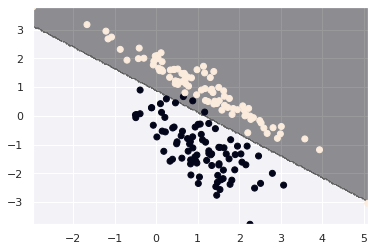

In [9]:
model = Logit(0, 0, learning_rate = 0.7)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

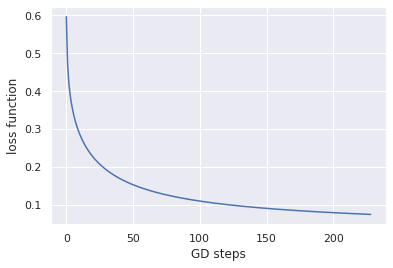

In [10]:
plt.plot(model.loss_history)
plt.xlabel('GD steps')
plt.ylabel('loss function')
plt.show()

Как и ожидалось, с ростом шагов градиентного спуска значение функции потери достаточно резко падает.

## PART 2: Support Vector Machines

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient 

Show how these parameters affect accuracy, roc_auc and f1 score. 
Make plots for the dependencies between metrics and parameters. 
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import matplotlib.colors as colors

In [58]:
logs = np.logspace(-2, 2, num = 20)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 88)
colors_list = list(colors._colors_full_map.values())

# Рассматриваем разные ядра с учетом разных гиперпараметров.
parameters = {"linear" : {"args" : {"kernel":'linear'}, "color" : colors_list[5]},
              "polynomial 3" : {"args" : {"kernel":'poly', "degree":3}, "color" : colors_list[15]},
              "polynomial 4" : {"args" : {"kernel":'poly', "degree":4}, "color" : colors_list[20]},
              "RBF 0.1" : {"args" : {"kernel":'rbf', "gamma":0.1}, "color" : colors_list[30]},
              "RBF 0.5" : {"args" : {"kernel":'rbf', "gamma":0.5}, "color" : colors_list[50]}}

for kernel in parameters.values():
  kernel["test"] = {"accuracy": list(), "roc_auc": list(), "f1_score": list()}
  kernel["train"] = {"accuracy": list(), "roc_auc": list(), "f1_score": list()}
  
  for reg_c in logs:
    clf = SVC(**kernel["args"], C = reg_c)
    clf.fit(X_train, y_train)

    # Для тестового набора.
    ypred = clf.predict(X_test)
    kernel["test"]["accuracy"].append(accuracy_score(y_test, ypred))
    kernel["test"]["roc_auc"].append(roc_auc_score(y_test, ypred))
    kernel["test"]["f1_score"].append(f1_score(y_test, ypred))

    # Для тренировочного набора (используем для оценки overfitting).
    ypred = clf.predict(X_train)
    kernel["train"]["accuracy"].append(accuracy_score(y_train, ypred))
    kernel["train"]["roc_auc"].append(roc_auc_score(y_train, ypred))
    kernel["train"]["f1_score"].append(f1_score(y_train, ypred))

  print(kernel)


{'args': {'kernel': 'linear'}, 'color': '#894585', 'test': {'accuracy': [0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9444444444444444, 0.9444444444444444], 'roc_auc': [0.9565217391304348, 0.9565217391304348, 0.9565217391304348, 0.9565217391304348, 0.9565217391304348, 0.9565217391304348, 0.9565217391304348, 0.9565217391304348, 0.9565217391304348, 0.9565217391304348, 0.9180602006688964, 0.9180602006688964, 0.9180602006688964, 0.9180602006688964, 0.9180602006688964, 0.9180602006688964, 0.9180602006688964, 0.9013377926421405, 0.9230769230769231, 0.9230769230769231], 'f1_score': [0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 

Посмотрим, как параметры влияют на метрики и построим графики зависимости для каждой из них. Сначала рассмотрим $accuracy$:

In [64]:
def plot_svm(val, metric, train = False):
    plt.xscale("log")
    plt.xlabel("reg_coeff")
    plt.ylabel(metric)
    plt.ylim(0.3, 1.1)
    y_val = parameters[val]["test"][metric]
    color_val = parameters[val]["color"]
    plt.plot(logs, y_val, label = val, c = color_val)
    if train:
      y_val = parameters[val]["train"][metric]
      plt.plot(logs, y_val, linestyle = "--", label = val, c = color_val)

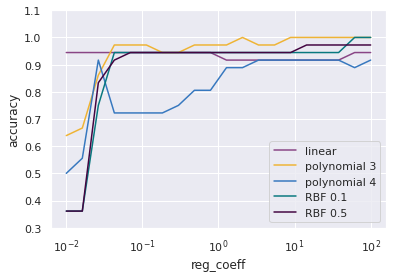

In [65]:
for val in parameters:
  plot_svm(val, "accuracy")
plt.legend()
plt.show()

Теперь построим график зависимости для метрики $roc\_auc$:

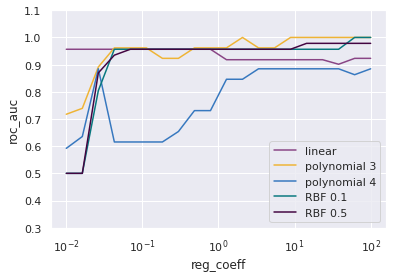

In [66]:
for val in parameters:
  plot_svm(val, "roc_auc")
plt.legend()
plt.show()

Наконец, построим график зависимости метрики $F1-score$ от параметров:

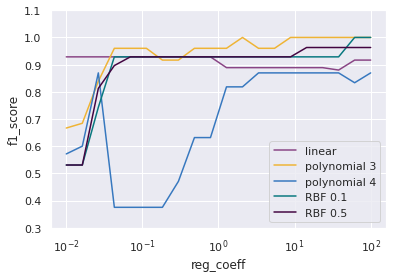

In [67]:
for val in parameters:
  plot_svm(val, "f1_score")
plt.legend()
plt.show()

_Вывод_: в общем и целом, характер влияния параметров на все рассматриваемые метрики идентичен:   
1) С ростом коэффициента регуляризации метрики разных ядер сходятся к приблизительно единому значению, при этом для большинства (за исключением $linear$) ядер значение метрики выросло;   
2) Характер изменения графиков для разных ядер схож, только полином 4-ой степени показывает значительные колебания, резко падая при коэффициенте регуляризации, близком к $0.1$;   
3) Касаемо гиперпараметров: для $RBF$ значение $gamma$ не сильно повлияло на результат, а для $polynomial$, как было отмечено выше, показатель степени $degree=4$ повышает восприимчивость к регуляризации.

Чтобы оценить $overfitting$, построим графики для ядер, отражающие $accuracy$ для тренировочных и тестовых наборов данных соответственно:

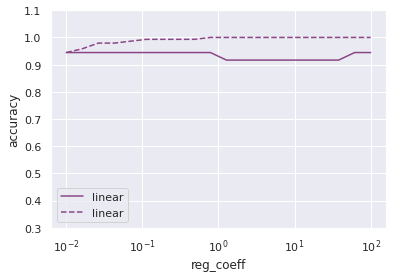

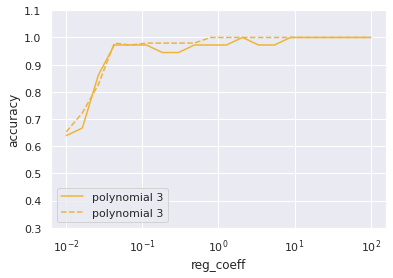

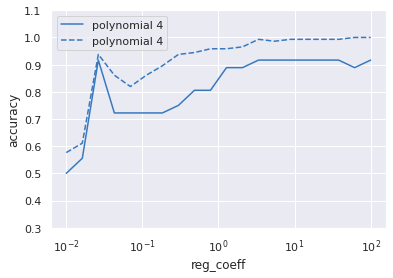

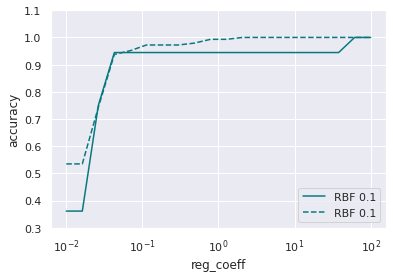

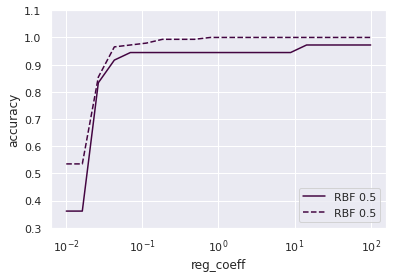

In [68]:
for val in parameters:
  plot_svm(val, "accuracy", train = True)
  plt.legend()
  plt.show()

Если присутствует $overfitting$, то линия тренировочных данных на графике лежит выше, а также линия тестовых данных идет на спад ближе к правой границе.   
Таким образом, $overfitting$ однозначно присутствует у $linear$ и $polynomial$ 4 степени, $RBF$ с $\gamma=0.5$ на грани (разрыв линий не такой большой и линия тестовых данных все-таки растет).

## PART 3: Natural Language Processing

#### 7. [1.75 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors: 
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center> 
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr> 
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td> 
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td> 
        <tr><td> ... </td><td> ... </td><td> 
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset 
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and apply either stemming or lemmatization of the words (on your choice)
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

In [18]:
!git clone https://github.com/DaryaSushkova/ml_data.git

Cloning into 'ml_data'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.


In [19]:
!unzip 'ml_data/prose.zip'

Archive:  ml_data/prose.zip
   creating: prose/
   creating: prose/Blok/
  inflating: prose/Blok/info.csv     
  inflating: prose/Blok/╨б╨║╨░╨╖╨║╨░ ╨╛ ╤В╨╛╨╣, ╨║╨╛╤В╨╛╤А╨░╤П ╨╜╨╡ ╨┐╨╛╨╣╨╝╨╡╤В ╨╡╤С.txt  
  inflating: prose/Blok/╨б╨╛╨│╤А╨░╨╢╨┤╨░╨╜╨╡.txt  
  inflating: prose/Blok/╨Ф╨╡╨▓╤Г╤И╨║╨░ ╤А╨╛╨╖╨╛╨▓╨╛╨╣ ╨║╨░╨╗╨╕╤В╨║╨╕ ╨╕ ╨╝╤Г╤А╨░╨▓╤М╨╕╨╜╤Л╨╣ ╤Ж╨░╤А╤М.txt  
  inflating: prose/Blok/╨Э╨╕ ╤Б╨╜╤Л, ╨╜╨╕ ╤П╨▓╤М.txt  
   creating: prose/Bryusov/
  inflating: prose/Bryusov/info.csv  
  inflating: prose/Bryusov/╨а╨╡╤Б╨┐╤Г╨▒╨╗╨╕╨║╨░ ╨о╨╢╨╜╨╛╨│╨╛ ╨Ъ╤А╨╡╤Б╤В╨░.txt  
  inflating: prose/Bryusov/╨а╨╡╤П ╨б╨╕╨╗╤М╨▓╨╕╤П.txt  
  inflating: prose/Bryusov/╨а╨░╤Б╤Б╨║╨░╨╖╤Л ╨Ь╨░╤И╨╕, ╤Б ╤А╨╡╨║╨╕ ╨Ь╨╛╨╗╨╛╨│╨╕, ╨┐╨╛╨┤ ╨│╨╛╤А╨╛╨┤╨╛╨╝ ╨г╤Б╤В╤О╨╢╨╜╨░.txt  
  inflating: prose/Bryusov/╨б╨╡╤Б╤В╤А╤Л.txt  
  inflating: prose/Bryusov/╨б╨╡╨╝╤М ╨╖╨╡╨╝╨╜╤Л╤Е ╤Б╨╛╨▒╨╗╨░╨╖╨╜╨╛╨▓.txt  
  inflating: prose/Bryusov/╨в╨╡╨┐╨╡╤А╤М, - ╨║╨╛╨│╨┤╨░ ╤П ╨┐╤А╨╛╤Б╨╜╤Г╨╗╤Б╤П....txt  
  inflating: prose/Bryusov/╨з╨╡╤А╨╡╨╖ ╨┐╤П╤В╨╜╨░╨┤╤Ж╨░

In [20]:
import re
from glob import glob
import nltk
from nltk.tokenize import sent_tokenize

nltk.download('punkt')

# Определяем функцию для чтения текста для заданного автора.
def get_sents(author):
    lines = []
    # Проход по текстам заданного автора.
    for texts in glob(f"prose/{author}/*.txt"):
        for line in open(texts):
            lines.append(line.strip())
    # Дополнительные манипуляции на всякий случай.
    text = ' '.join(lines)
    sent_text = nltk.tokenize.sent_tokenize(text, language = 'russian')
    return [sent for sent in sent_text if len(sent) >= 15]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Авторы, которых я выбрала: Пушкин, Гоголь, Герцен, Чехов, Тургенев, Лермонтов. Я очень-очень люблю Достоевского и Толстого, но у них слишком тяжелые произведения для этого мира...   
Стоит отметить, что данные пропорции высчитываются с единичным коэффициентом, то есть берется количество предложений, численно равных пропорции.   
Для обеспечения максимальной случайности я буду использовать метод $np.random.choice()$. 

In [21]:
# Задаем списки выбранных авторов и соответствующих пропорций.
authors = ["Pushkin", "Gogol", "Herzen", "Chekhov", "Turgenev", "Lermontov"]
proportions = [5000, 15000, 8000, 11000, 20000, 3000]
# Дополнительно создаем русский аналог для датасета.
optional = ["Пушкин", "Гоголь", "Герцен", "Чехов", "Тургенев", "Лермонтов"]
# Группируем в кортеж.
map = zip(authors, optional, proportions)

# Списки для формирования столбцов.
sentences = list()
ru_authors = list()

np.random.seed(8)
for au, opt, prop in map:
    # Получаем список из prop текущей русской фамилии автора.
    list_au = [opt] * prop
    list_sent = list(np.random.choice(get_sents(au), prop, replace = False))
    # Объединяем со списками соответствующих столбцов.
    ru_authors += list_au
    sentences += list_sent

In [22]:
# Формируем датасет, юху!
dataset = pd.DataFrame(data = {"sentence": sentences, "author": ru_authors})
dataset

,sentence,author
0,"Долго смотрел я издали на сельский дом, опять ...",Пушкин
1,Пятнадцать возов были подвезены на лошадях в б...,Пушкин
2,"Я последовал его совету и, поужинав с большим ...",Пушкин
3,Господские крестьяне взбунтовались; иноверцы и...,Пушкин
4,"Губернатор, измученный болезнию, от которой он...",Пушкин
...,...,...
61995,"- Держу пятьдесят рублей против пяти, что ...",Лермонтов
61996,"- продолжал он, - даю вам честное, благородно...",Лермонтов
61997,в воскресенье ты пойдешь в церковь без новой л...,Лермонтов
61998,"Когда он опустился на скамью, то прямой стан е...",Лермонтов


Можно увидеть, что некоторые предложения имеют не совсем стандартную форму, что связано со спецификой прямой речи в тексте, цитатами, чередованием одного с другим и т.п..   
В любом случае, использовались библиотечные методы, которые явно сработали лучше, чем какое-нибудь авторское решение на основе анализа каждого символа :)

После формирования датасета переходим к препроцессингу. Я буду использовать лемматизатор (морфологический анализатор), так как для русского языка данный вариант более подходящий нежели стемминг.

In [23]:
import string

# Стоп-слова.
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')

# Определяем токенизатор слов.
word_tokenizer = nltk.WordPunctTokenizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [24]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.0 MB/s 
     |████████████████████████████████| 8.2 MB 15.5 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=1a774c48b7414592d066404970a4944ab7d2f71a36c6cce98117edc373920dfe
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt


In [25]:
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

# Определяем функцию для процессинга текста (в рамках задания - предложения).
# Реализация схожа с приведенной на семинаре.

def process_sent(text):
    targets = []
    # Конвертация к нижнему регистру и токенизация.
    text_lower = text.lower()
    tokens = word_tokenizer.tokenize(text_lower)
    # Удаление стоп-слов, знаков пунктуации и цифр.
    tokens = [word for word in tokens if (word not in string.punctuation and word not in stop_words and word not in string.digits)]
    result = []
    # Тут же определим лемматизацию.
    for word in tokens:
        word_norm = morph.parse(word)[0].normal_form
        result.append(word_norm)
    return result

def process_data(data):
    return [process_sent(sent) for sent in data]

# Обрабатываем наш датасет.
dataset['lemmatization'] = process_data(dataset['sentence'])
dataset

,sentence,author,lemmatization
0,"Долго смотрел я издали на сельский дом, опять ...",Пушкин,"[долго, смотреть, издали, сельский, дом, я, по..."
1,Пятнадцать возов были подвезены на лошадях в б...,Пушкин,"[пятнадцать, воз, подвезти, лошадь, близкий, р..."
2,"Я последовал его совету и, поужинав с большим ...",Пушкин,"[последовать, совет, поужинать, больший, аппет..."
3,Господские крестьяне взбунтовались; иноверцы и...,Пушкин,"[господский, крестьянин, взбунтоваться, иновер..."
4,"Губернатор, измученный болезнию, от которой он...",Пушкин,"[губернатор, измученный, болезние, который, ум..."
...,...,...,...
61995,"- Держу пятьдесят рублей против пяти, что ...",Лермонтов,"[дерзить, пятьдесят, рубль, против, пять, пист..."
61996,"- продолжал он, - даю вам честное, благородно...",Лермонтов,"[продолжать, давать, честной, благородный, сло..."
61997,в воскресенье ты пойдешь в церковь без новой л...,Лермонтов,"[воскресение, пойти, церковь, новый, лента]"
61998,"Когда он опустился на скамью, то прямой стан е...",Лермонтов,"[опуститься, скамья, прямой, стан, согнуться, ..."


Теперь переходим к векторизации слов:

In [26]:
# Создаем лист из слов, полученных в результате лемматизации, для каждого предложения датасета.
lemmatization_list = [' '.join(words) for words in dataset["lemmatization"]]

In [27]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

bag_matrix = CountVectorizer(max_features = 500).fit_transform(lemmatization_list)
bag_array = np.asarray(bag_matrix.todense())
tfid_matrix = TfidfVectorizer(max_features = 500).fit_transform(lemmatization_list)
tfid_array = np.asarray(tfid_matrix.todense())

# Работаем с bag_of_words и tfidf.
dataset["bag_of_words"] = [bag_array[index] for index in range(bag_array.shape[0])]
dataset["tfidf"] = [tfid_array[index] for index in range(tfid_array.shape[0])]

В своей реализации я использовала значение $max\_features=500$, иначе говоря простым языком, рассматривается 500 наиболее часто встречающихся слов.   
Числа (целые) в столбце $bag-of-words$ показывают для текущего предложения количество каждого из 500 наиболее частых слов (то есть если значение равно $0$, то слово не встречалось в предложении, если значение равно $n$, то слово встречалось в предложении $n$ раз).
Числа (вещественные) в столбце $tfidf$ показывают для текущего предложения отношение числа вхождений каждого из 500 наиболее частых слов к общему числу слов датасета. Иначе говоря, они характеризуют важность соответстсующего слова в рамках всего датасета.   
То, что в видимой части датасета отражаются только нули - нормально, там 500 позиций в списках, так что ненулевые значения идут дальше.

In [28]:
dataset

,sentence,author,lemmatization,bag_of_words,tfidf
0,"Долго смотрел я издали на сельский дом, опять ...",Пушкин,"[долго, смотреть, издали, сельский, дом, я, по...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Пятнадцать возов были подвезены на лошадях в б...,Пушкин,"[пятнадцать, воз, подвезти, лошадь, близкий, р...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"Я последовал его совету и, поужинав с большим ...",Пушкин,"[последовать, совет, поужинать, больший, аппет...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Господские крестьяне взбунтовались; иноверцы и...,Пушкин,"[господский, крестьянин, взбунтоваться, иновер...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"Губернатор, измученный болезнию, от которой он...",Пушкин,"[губернатор, измученный, болезние, который, ум...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
61995,"- Держу пятьдесят рублей против пяти, что ...",Лермонтов,"[дерзить, пятьдесят, рубль, против, пять, пист...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
61996,"- продолжал он, - даю вам честное, благородно...",Лермонтов,"[продолжать, давать, честной, благородный, сло...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
61997,в воскресенье ты пойдешь в церковь без новой л...,Лермонтов,"[воскресение, пойти, церковь, новый, лента]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
61998,"Когда он опустился на скамью, то прямой стан е...",Лермонтов,"[опуститься, скамья, прямой, стан, согнуться, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn) 

* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)
* using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks
* make several plots to address the dependence between F1 score and parameters
* plot confusion matrix for train and test samples
* compute some relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn) 
* make conclusions about the performance of your models


В рамках данного задания я выбрала следующих авторов: Пушкин и Лермонтов. В принципе, оценить сбалансированность классов можно было и без кода, с учетом того, что нам известны пропорции: $5k:3k$, то есть класс Пушкина больше класса Лермонтова в $1,(6)$ раз, что является не очень хорошим показателем в контексте сбалансированности. Однако по данным пропорциям это лучший вариант, который мы можем рассмотреть.   
Код расчетов тем не менее приведу: 

In [29]:
# Формируем дополнительный датасет для выбранных авторов.
dataset_bin = dataset[(dataset["author"] == "Пушкин") | (dataset["author"] == "Лермонтов")]
first = sum(dataset_bin["author"] == "Пушкин")
second = sum(dataset_bin["author"] == "Лермонтов")
print(max(first, second) / min(first, second))

dataset_bin

1.6666666666666667


,sentence,author,lemmatization,bag_of_words,tfidf
0,"Долго смотрел я издали на сельский дом, опять ...",Пушкин,"[долго, смотреть, издали, сельский, дом, я, по...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Пятнадцать возов были подвезены на лошадях в б...,Пушкин,"[пятнадцать, воз, подвезти, лошадь, близкий, р...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"Я последовал его совету и, поужинав с большим ...",Пушкин,"[последовать, совет, поужинать, больший, аппет...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Господские крестьяне взбунтовались; иноверцы и...,Пушкин,"[господский, крестьянин, взбунтоваться, иновер...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"Губернатор, измученный болезнию, от которой он...",Пушкин,"[губернатор, измученный, болезние, который, ум...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
61995,"- Держу пятьдесят рублей против пяти, что ...",Лермонтов,"[дерзить, пятьдесят, рубль, против, пять, пист...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
61996,"- продолжал он, - даю вам честное, благородно...",Лермонтов,"[продолжать, давать, честной, благородный, сло...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
61997,в воскресенье ты пойдешь в церковь без новой л...,Лермонтов,"[воскресение, пойти, церковь, новый, лента]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
61998,"Когда он опустился на скамью, то прямой стан е...",Лермонтов,"[опуститься, скамья, прямой, стан, согнуться, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [30]:
# Будем считать, Пушкин - "положительный" класс, а Лермонтов - "негативный".
old_classes = [(dataset_bin["author"] == "Пушкин") + 0]
y = np.array([-1, 1])[tuple(old_classes)]
X = np.vstack(dataset_bin["tfidf"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 8)

Теперь используем $GridSearchCV$ для поиска наилучших параметров:

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [32]:
# Для библиотечной модели SVM.
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[0.001, 0.01, 0.1, 1, 10, 100]}
svr = SVC(probability=True, verbose = False)
clf = GridSearchCV(svr, parameters, scoring = 'f1', verbose=2, cv=2)
clf.fit(X_train, y_train)
print(clf.best_params_)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] END .............................C=0.001, kernel=linear; total time=  11.7s
[CV] END .............................C=0.001, kernel=linear; total time=  12.8s
[CV] END ................................C=0.001, kernel=rbf; total time=  13.2s
[CV] END ................................C=0.001, kernel=rbf; total time=   9.7s
[CV] END ...............................C=0.001, kernel=poly; total time=   8.2s
[CV] END ...............................C=0.001, kernel=poly; total time=   7.8s
[CV] END ..............................C=0.01, kernel=linear; total time=   7.5s
[CV] END ..............................C=0.01, kernel=linear; total time=   7.3s
[CV] END .................................C=0.01, kernel=rbf; total time=  10.3s
[CV] END .................................C=0.01, kernel=rbf; total time=  10.5s
[CV] END ................................C=0.01, kernel=poly; total time=   8.7s
[CV] END ................................C=0.01,

In [33]:
# Для собственной модели.
parameters = {'learning_rate': [0.1, 0.4, 0.7], 'beta': [0, 0.1, 1.0], 'gamma': [0, 0.1, 1.0, 2.0]}
clf = GridSearchCV(Logit(), parameters, scoring='f1', verbose=2, cv=2)
clf.fit(X_train, y_train)
print(clf.best_params_)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV] END .................beta=0, gamma=0, learning_rate=0.1; total time=   2.2s
[CV] END .................beta=0, gamma=0, learning_rate=0.1; total time=   2.1s
[CV] END .................beta=0, gamma=0, learning_rate=0.4; total time=   2.1s
[CV] END .................beta=0, gamma=0, learning_rate=0.4; total time=   2.1s
[CV] END .................beta=0, gamma=0, learning_rate=0.7; total time=   2.0s
[CV] END .................beta=0, gamma=0, learning_rate=0.7; total time=   2.1s
[CV] END ...............beta=0, gamma=0.1, learning_rate=0.1; total time=   2.1s
[CV] END ...............beta=0, gamma=0.1, learning_rate=0.1; total time=   2.1s
[CV] END ...............beta=0, gamma=0.1, learning_rate=0.4; total time=   2.0s
[CV] END ...............beta=0, gamma=0.1, learning_rate=0.4; total time=   2.0s
[CV] END ...............beta=0, gamma=0.1, learning_rate=0.7; total time=   2.1s
[CV] END ...............beta=0, gamma=0.1, learn

Таким образом, для $SVC$ лучшие параметры: $RBF$ и $C = 1.0$;   
для $Logit$ лучшие параметры: $β=0, γ=0.1, lr=0.1$.

Прошу прощения, позаимствую код из семинара №6:

In [34]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

def show_results(test_y, pred, proba, title):
    print("Precision: {0:6.2f}".format(precision_score(test_y, pred, average='macro')))
    print("Recall: {0:6.2f}".format(recall_score(test_y, pred, average='macro')))
    print("F1-measure: {0:6.2f}".format(f1_score(test_y, pred, average='macro')))
    print("Accuracy: {0:6.2f}".format(accuracy_score(test_y, pred)))
    print("ROC-AUC  =  {0:6.2f}".format(roc_auc_score(test_y, proba[:,1]),))
    print('\n')
    labels = ['negative','positive']

    #classification_report
    sns.heatmap(data=confusion_matrix(test_y, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.show()

Теперь построим $confusion$ матрицы на тестовых и тренировочных данных, а также рассчитаем метрики с учетом найденных наилучших параметров. Для модели SVC ($linear$ ядро):

Precision:   0.71
Recall:   0.68
F1-measure:   0.69
Accuracy:   0.73
ROC-AUC  =    0.75




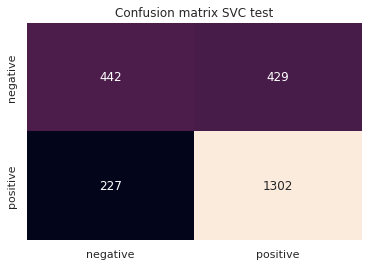

In [35]:
clf = SVC(probability = True, kernel = 'rbf', C = 1.0)
clf.fit(X_train, y_train)
# Для тестового набора.
pred = clf.predict(X_test)
proba  = clf.predict_proba(X_test)
show_results(y_test, pred, proba, "Confusion matrix SVC test")

Precision:   0.88
Recall:   0.85
F1-measure:   0.86
Accuracy:   0.87
ROC-AUC  =    0.91




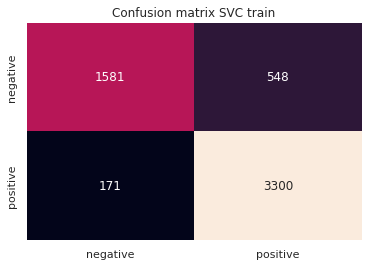

In [36]:
# Для тренировочного набора.
pred = clf.predict(X_train)
proba  = clf.predict_proba(X_train)
show_results(y_train, pred, proba, "Confusion matrix SVC train")

Теперь проделаем то же самое для нашей собственной $Logit$ модели. Очень важный момент - по какой-то неведомой причине $GridSearchCV$ выдает в качестве набора лучших параметров тот, при котором одна из меток никогда не предсказывается для модели. Выглядит это следующим образом:

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision:   0.32
Recall:   0.50
F1-measure:   0.39
Accuracy:   0.64
ROC-AUC  =    0.49




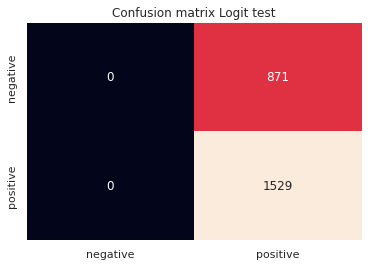

In [37]:
clf = Logit(0, 0.1, learning_rate = 0.1)
clf.fit(X_train, y_train)
# Для тестового набора.
pred = clf.predict(X_test)
proba = clf.predict_proba(X_test)
show_results(y_test, pred, proba, "Confusion matrix Logit test")

В $confusion$ матрице в первом столбце стоят нули, как и говорилось выше, метку не удается предсказать. Непонятно, почему $GridSearchCV$ выдал такой результат, учитвая, что показатель $F1-score$ также не является лучшим для всех рассматриваемых вариантов. Например, если задать $β=0,γ=2.0,lr=0.7$, то получатся следующие метрики:

Precision:   0.53
Recall:   0.52
F1-measure:   0.52
Accuracy:   0.59
ROC-AUC  =    0.53




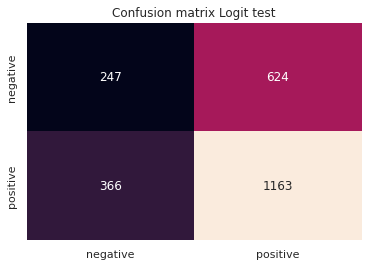

In [38]:
clf = Logit(0, 2.0, learning_rate = 0.7)
clf.fit(X_train, y_train)
# Для тестового набора.
pred = clf.predict(X_test)
proba = clf.predict_proba(X_test)
show_results(y_test, pred, proba, "Confusion matrix Logit test")

Precision:   0.53
Recall:   0.53
F1-measure:   0.52
Accuracy:   0.58
ROC-AUC  =    0.54




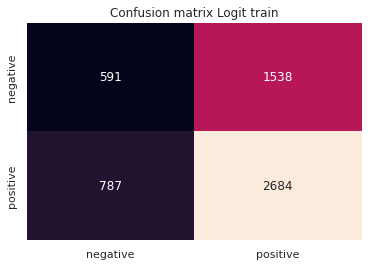

In [39]:
# Для тренировочного набора.
pred = clf.predict(X_train)
proba  = clf.predict_proba(X_train)
show_results(y_train, pred, proba, "Confusion matrix Logit train")

Учитывая непонятную реакцию $GridSearchCV$ на авторскую модель, будем анализировать результаты по параметрам, которые выдали относительно адекватные значения и смогли спрогнозировать все метки.

_Вывод по матрицам и метрикам_: как и ожидалось, библиотечная модель $SVC$ дала более хорошие результаты в сравнении с авторской $Logit$ (хотя для $SVC$ тоже результаты так себе, матрицы не полностью диагональны, а метрики не достигают $0.8$). В случае авторской модели матрицы имеют плохой вид, а метрики не намного превышают $0.5$.   
Объяснить не самые хорошие показатели метрик, матриц и работу $GridSearchCV$ можно сравнительно небольшой выборкой данных и несовершенством модели.

#### 9. [1 point] Analysing ROC AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate. Pay attention to `thresholds` parameter in sklearn roc_curve 

_Примечание_: в этом номере я буду использовать логистическую регрессию из $sklearn$ (семинариcт дал согласие).

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve

# Задаем модели.
logistic = LogisticRegression()
logistic.fit(X_train, y_train)
svc = SVC()
svc.fit(X_train, y_train)
proba_logistic = logistic.decision_function(X_test)
proba_svc = svc.decision_function(X_test)

In [42]:
rate = 0.3

def get_fpr(proba, title):
    # Обращаю внимание на roc_curve, как и просили.
    fpr, tpr, thresholds = roc_curve(y_test, proba)

    plt.title(title)
    plt.xlabel("fpr")
    plt.ylabel("tpr")

    # Отображаем кривую ROC.
    plt.plot(fpr, tpr, color = colors_list[5])
    # Отображаем линию-порог в 30%.
    plt.plot([rate, rate], [0.0, 1.0], linestyle = '--', color = colors_list[10])

    # Искомое пороговое значение и прогноз на его основе.
    threshold = thresholds[np.argmin(np.abs(fpr - rate))]
    pred = np.where(proba < threshold, -1, 1)
    matrix = confusion_matrix(y_test, pred, labels = [1, -1])
    print(f"{matrix[1, 0] / sum(matrix[1]) * 100}% fpr")

30.080367393800227% fpr


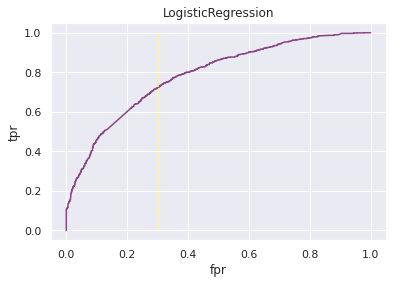

In [43]:
# Для логистической регрессии.
get_fpr(proba_logistic, "LogisticRegression")

29.850746268656714% fpr


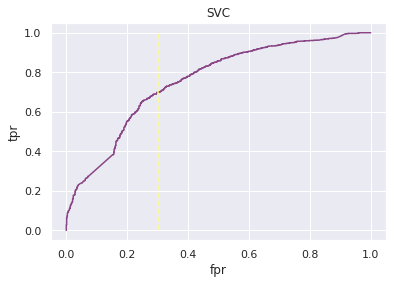

In [44]:
# Для SVC.
get_fpr(proba_svc, "SVC")

### Multiclass logit

#### 10. [1 point] Take the One-VS-One classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html">OneVsOneClassifier</a>

* use the data you got at the previous step for 6 authors
* divide the data into train and test samples with 0.7 split rate
* using GridSearchCV - find the best parameters for the models (by F1 score)
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (use sklearn)

In [45]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import make_scorer

In [46]:
# Уточним, какие параметры можно рассматривать.
svr = OneVsOneClassifier(Logit(), n_jobs=-1)
print(svr.get_params().keys())

dict_keys(['estimator__beta', 'estimator__gamma', 'estimator__learning_rate', 'estimator__max_iter', 'estimator__random_state', 'estimator__tolerance', 'estimator', 'n_jobs'])


In [47]:
parameters = {'estimator__learning_rate': [0.1, 0.4, 0.7], 'estimator__beta': [0.0, 0.1, 1.0], 'estimator__gamma': [0.0, 0.1, 1.0]}
my_scorer = make_scorer(f1_score, greater_is_better = True, average = 'micro')

X_train, X_test, y_train, y_test = train_test_split(np.vstack(dataset["tfidf"]), dataset["author"], test_size = 0.3, random_state = 88)
clf = GridSearchCV(svr, parameters, scoring = my_scorer)
clf.fit(X_train, y_train)
predict = clf.predict(X_test)
print('\n\n\nOneVsOne Strategy')
print('Best parameters: ', clf.best_params_)
print("F1 score  = {0:6.2f}".format(clf.score(X_test, y_test)))




OneVsOne Strategy
Best parameters:  {'estimator__beta': 0.0, 'estimator__gamma': 0.1, 'estimator__learning_rate': 0.1}
F1 score  =   0.18


Очень интересно, что в текущем номере мы получили такие же параметры, как и в 7. Только теперь результат, а именно значение $F1-score$ еще более страшный 🚩   
Что с этим делать - не знаю, вроде и нашла, что требовалось, а послевкусие ужасное...


Построим $confusion$ матрицы для тестового и тренировочного набора. Немножко модифицирую ранее использовавшуюся функцию с семинара:

In [51]:
def show_results(test_y, pred, title):
    print("Precision: {0:6.2f}".format(precision_score(test_y, pred, average='micro')))
    print("Recall: {0:6.2f}".format(recall_score(test_y, pred, average='micro')))
    print("F1-measure: {0:6.2f}".format(f1_score(test_y, pred, average='micro')))
    print("Accuracy: {0:6.2f}".format(accuracy_score(test_y, pred)))
    print('\n')
    labels = ["Пушкин", "Гоголь", "Герцен", "Чехов", "Тургенев", "Лермонтов"]

    #classification_report
    sns.heatmap(data=confusion_matrix(test_y, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.show()

Precision:   0.18
Recall:   0.18
F1-measure:   0.18
Accuracy:   0.18




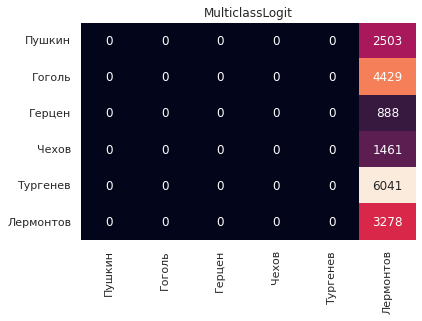

In [52]:
show_results(y_test, predict, "MulticlassLogit")

Вот, собственно, метрики и матрицы. И то, и другое - очень плохо. Ситуация с нулями в матрице повторилась, то же самое произошло, когда $GridSearchCV$ выдал неверные параметры в качестве наилучших. Предположу, что сейчас аналогичный вариант, однако в связи с очень долгой работой $GridSearchCV$ физически не хватает временных ресурсов для ручного подбора адекватного набора параметров.   
Почему такая ситуация в принципе возможна?   
1) Несовершенство модели - наиболее очевидный момент. Бедный студент пытался реализовать свой $Logit$ и вроде как с разделением классов он справился достаточно удачно, на реальном наборе данных ситуация оказалась плачевной;    
2) Несбалансированность классов: заданные пропорции, а также случайный подбор данных сказался, как мне кажется, на качестве датасета.

Вот как-то так! Спасибо за проверку ♥